# Lithium Oven Optic 6B

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.special import erf
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
from lens import design
plt.style.use('notes')
%load_ext autoreload
%autoreload 2

path = '/mnt/md0/Data/rariniello/Lithium_Oven/Lithium_Oven_Optic_6/'
lam = 0.796
tau = 30
# All length units are in um

Lithium oven 6B is a version of LO_6 designed to use the majority of the FACET II laser beam instead of only the central 30mm.

In [2]:
plasma, I, z, sim_start, sim_length, pulse = design.load_plasma_design(path)

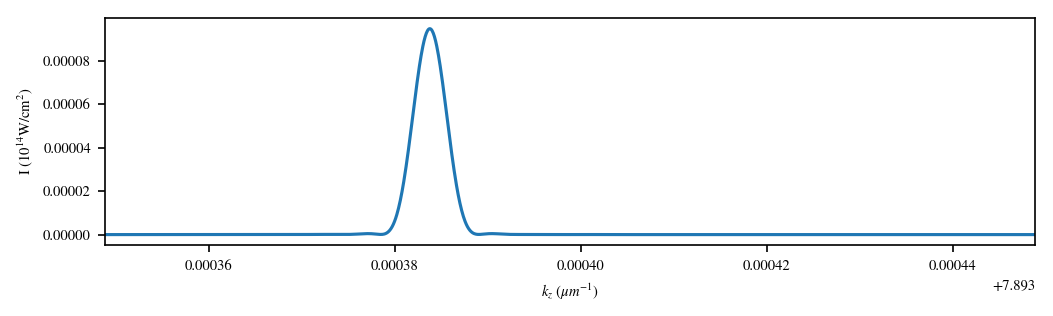

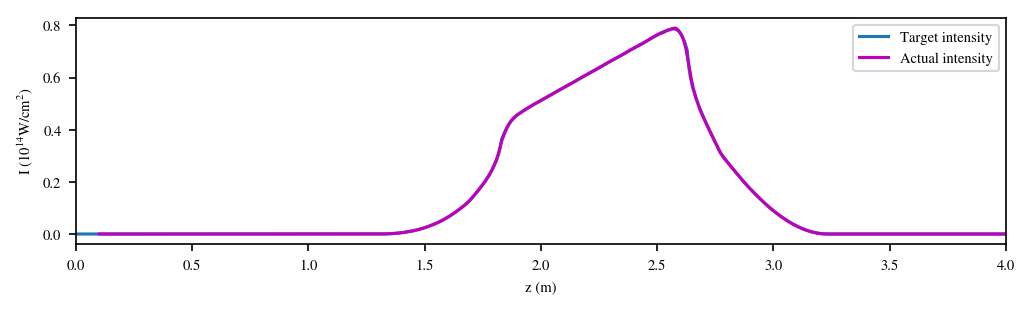

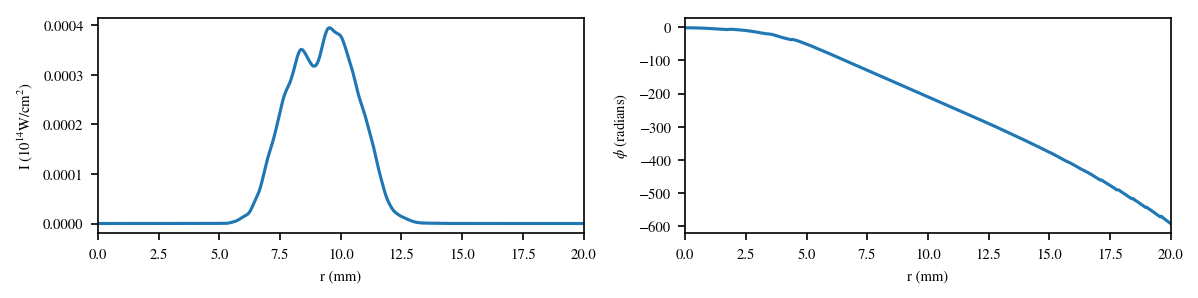

In [3]:
# Optic design upstream
width = 75
xlim = [0, 4]
z0 = 1.83075e6
z_optic, I_optic = design.extend_zI(z0, 'start', z, I, sim_start, sim_length)
r, E = design.calculate_tran_field(z_optic, I_optic, 20e3, width, lam, path, 10e-5, xlim, [0, 20])

In [7]:
L = 0.8e6
R_max = 25e3
X = 80e3
Nx = 2**13
n = 8
w0 = 30e3
ri = np.linspace(0, 25e3, len(r))
Ei = np.exp(-(ri/w0)**n)
rA, phiA, lensA, multi = design.create_lens_A(ri, Ei, r, E, L, path, lam, X, Nx)

Maximum phase change in one pixel 0.13 rad/um


Total input energy 2.98mJ


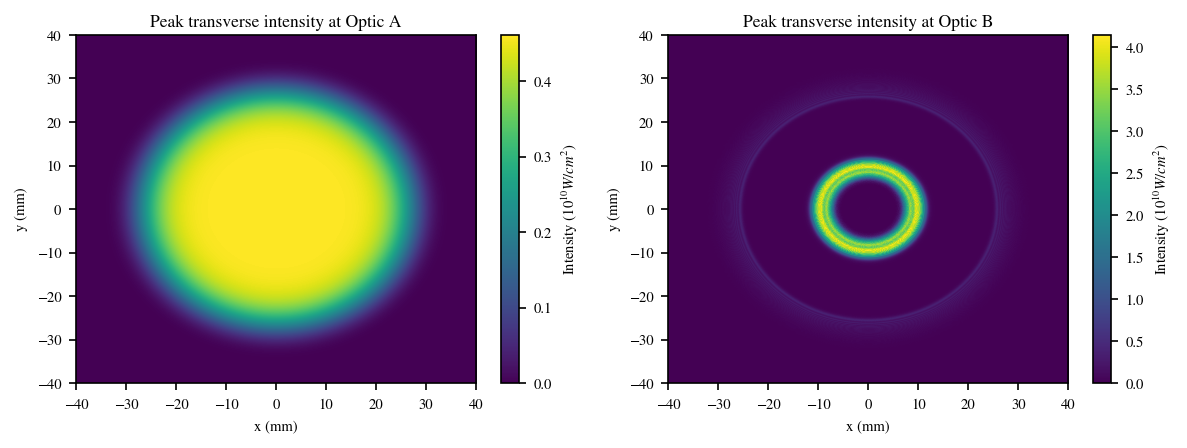

In [8]:
r0 = np.linspace(0, 100e3, 5000)
E0 = np.exp(-(r0/w0)**n)*multi
beam0 = design.propagate_to_lens_B(r0, E0, L, path, lam, lensA, tau, 20)

Maximum phase change in one pixel 0.32 rad/um


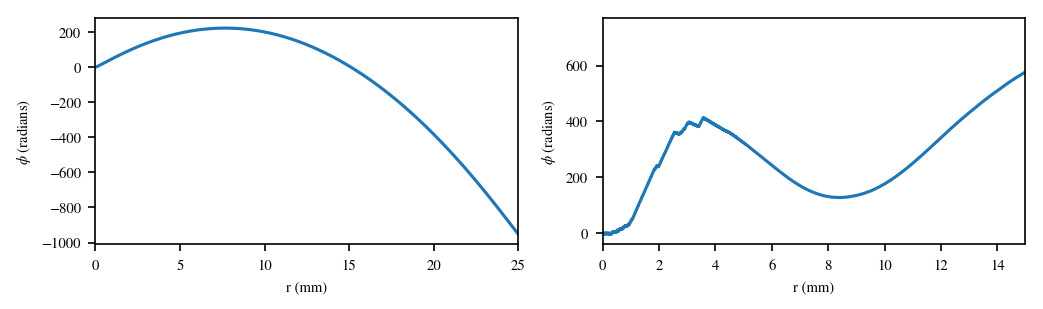

In [9]:
Nx = 2**12
X = 40e3
rB, phiB, lensB = design.create_lens_B(beam0, r, E, path, lam, X, Nx)
design.plot_phase(rA, phiA, rB, phiB, [0, 15])

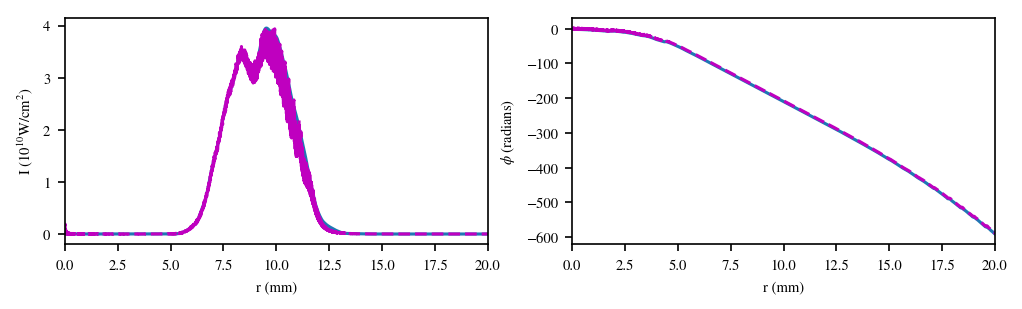

In [10]:
r1, e1 = design.field_after_lens_B(beam0, rB, phiB, r, E, [0, 20])

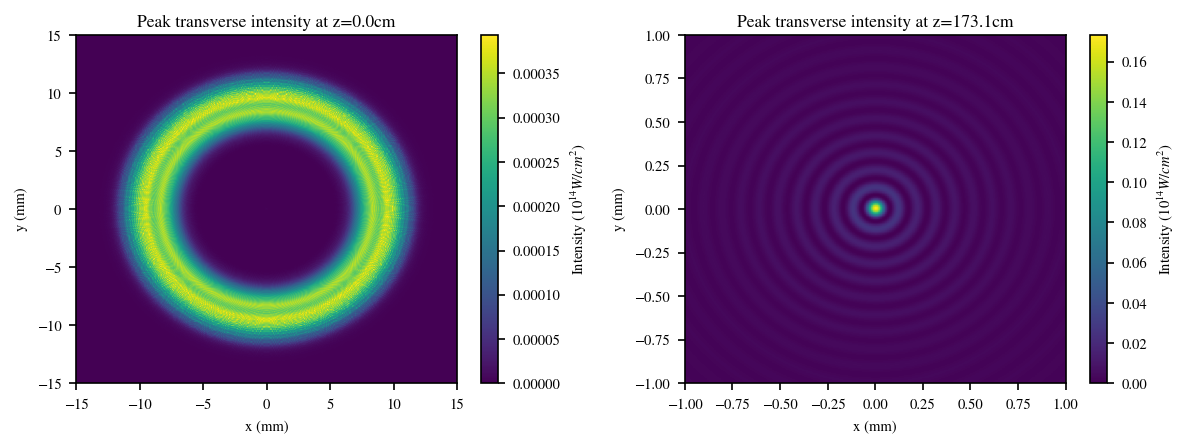

In [11]:
sel = r1 > 14e3 # Stop the outer rings from propagating
e1[sel] = 0.0
X = 30e3
Nx = 2**13
beam_start, pulseParams = design.propagate_to_start(r1, e1, z0-10e4, X, Nx, path, lam, tau, 20, [-1, 1])

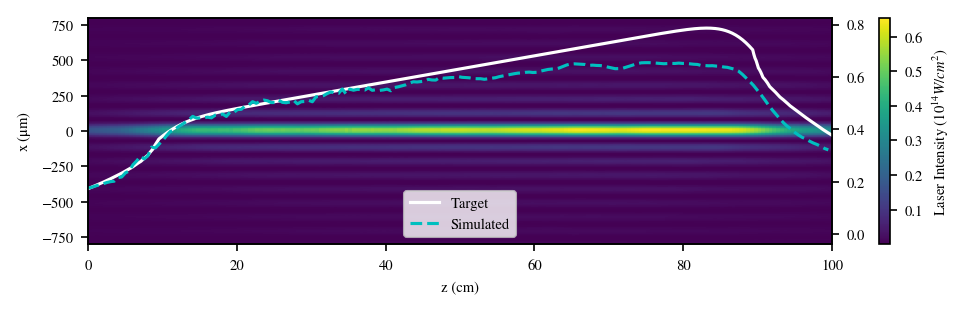

In [12]:
Nx = 2**11
Nz = 200
X = 10e3
Z = 100e4
I_0 = design.domain_test(X, Nx, Z, Nz, beam_start, pulseParams, z_optic, I_optic, z0-10e4, [-800, 800])

In [23]:
# Lens spacing tolerance study
Nz = 200
Z = 100e4
dL = np.array([-8e3, -4e3, -2e3, 0, 2e3, 4e3, 8e3])
I_dL = np.zeros((len(dL), Nz, 2**11))
for i in range(len(dL)):
    beam_L = design.propagate_to_lens_B(r0, E0, L+dL[i], path, lam, lensA, tau, 20, plot=False)
    r1, e1 = design.field_after_lens_B(beam_L, rB, phiB, r, E, [0, 20], plot=False)
    sel = r1 > 14e3 # Stop the outer rings from propagating
    e1[sel] = 0.0
    X = 30e3
    Nx = 2**13
    beam_start, pulseParams = design.propagate_to_start(r1, e1, z0-10e4, X, Nx, path, lam, tau, 20, [-1, 1], plot=False)
    Nx = 2**11
    X = 10e3
    I_dL[i, :, :] = design.domain_test(X, Nx, Z, Nz, beam_start, pulseParams, z_optic, I_optic, 
                                       z0-10e4, [-800, 800], plot=False)

Total input energy 2.98mJ
Total input energy 2.98mJ
Total input energy 2.98mJ
Total input energy 2.98mJ
Total input energy 2.98mJ
Total input energy 2.98mJ
Total input energy 2.98mJ


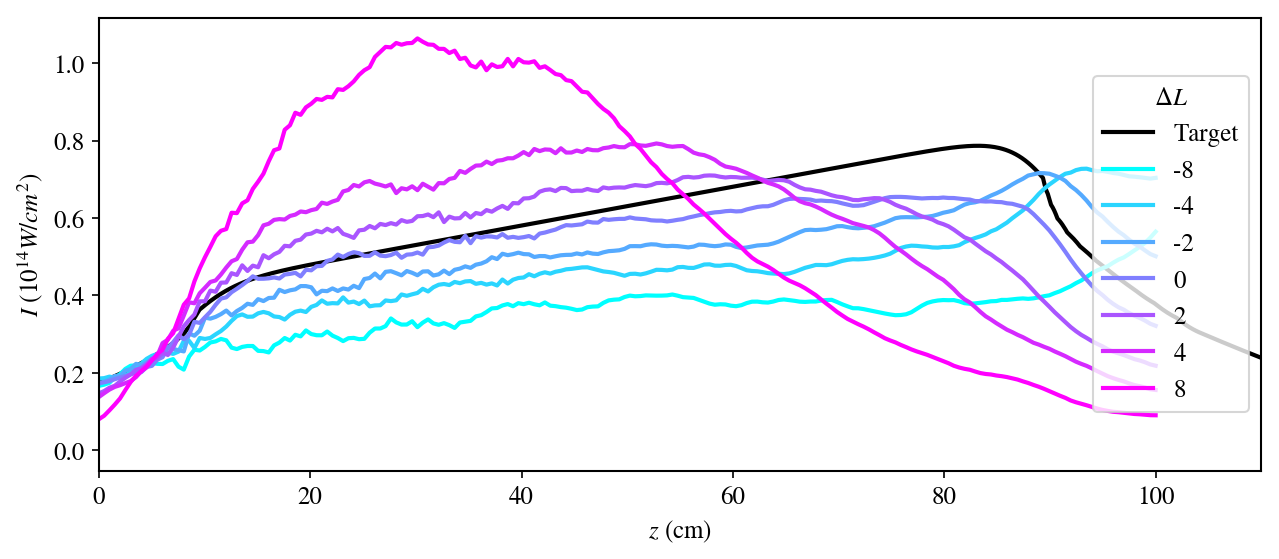

In [25]:
plt.style.use('presentation')
z = np.linspace(0, Z, Nz)
dz = z[1]-z[0]
start = z0-10e4
plt.figure(figsize=(10, 4), dpi=150)
colors = [plt.cm.cool(i) for i in np.linspace(0, 1, len(dL))]
ax = plt.subplot()
ax.set_prop_cycle('color', colors)
plt.xlabel(r'$z$ (cm)')
plt.ylabel(r'$I$ ($10^{14} W/cm^2$)')
plt.plot((z_optic-start-dz)/1e4, I_optic, 'k-', label='Target')
for i in range(len(dL)):
    plt.plot(z/1e4, I_dL[i, :, int(Nx/2)], label='%0.0f'%(dL[i]/1e3))
plt.legend(loc=7, title=r'$\Delta L$')
plt.xlim(0, Z/1e4+10)
plt.show()

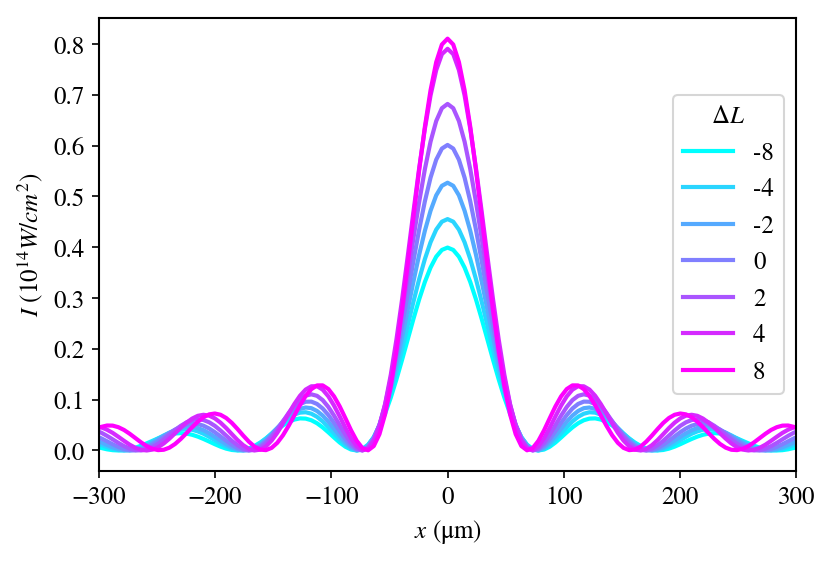

In [26]:
plt.figure(figsize=(6, 4), dpi=150)
colors = [plt.cm.cool(i) for i in np.linspace(0, 1, len(dL))]
x = np.linspace(-X/2, X/2, Nx, endpoint=False)
ax = plt.subplot()
ax.set_prop_cycle('color', colors)
plt.xlabel(r'$x$ ($\mathrm{\mu m}$)')
plt.ylabel(r'$I$ ($10^{14} W/cm^2$)')
for i in range(len(dL)):
    plt.plot(x, I_dL[i, int(Nz/2), :], label='%0.0f'%(dL[i]/1e3))
plt.legend(loc=7, title=r'$\Delta L$')
plt.xlim(-300, 300)
plt.show()
plt.style.use('notes')

In [16]:
# Calculate transverse offsets
def get_intensity(offset):
    Nx = 2**13
    X = 30e3
    Z = z0-10e4
    xlim = [-1, 1]

    pulseParams = {
        'Nt' : 2**6,
        'Nx' : Nx,
        'Ny' : Nx,
        'X' : X,
        'Y' : X,
        'T' : 3*tau,
        'lam' : lam,
        'path' : path,
        'load' : False,
        'threads' : 40,
        'cyl' : True,
        'tau' : tau,
        'name' : 'To_Start',
    }
    beam = laserbeam.Laser(pulseParams)
    e = beam.reconstruct_from_cyl(beam0.x[int(beam0.Nx/2):], beam0.e[int(beam0.Nx/2):, int(beam0.Nx/2)],beam.x, beam.y)
    phiB_2D = beam.reconstruct_from_cyl(rB, phiB, beam.x, beam.y)
    phiB_2D = np.roll(phiB_2D, offset, axis=0)
    e = e*np.exp(1j*phiB_2D)
    r_beam = np.sqrt(beam.x[:, None]**2 + beam.y[None, :]**2)
    sel = r_beam > 14e3 # Stop the outer rings from propagating
    e[sel] = 0.0
    beam.initialize_field(e)

    # Plot the initial transverse intensity
    #--------------------------------------------------------------------------
    e = beam.e
    I = beam.intensity_from_field(e)
    I = beam.prep_data(I)
    plt.figure(figsize=(10, 4), dpi=150)
    plt.subplot(121)
    plt.imshow(I, aspect='auto', extent=[-X/2e3, X/2e3, -X/2e3, X/2e3])
    cb = plt.colorbar()
    cb.set_label(r'Intensity ($10^{14} W/cm^2$)')
    plt.set_cmap('viridis')
    plt.xlabel(r'x (mm)')
    plt.ylabel(r'y (mm)')
    plt.title('Peak transverse intensity at z=0.0cm')

    # Plot the initial transverse intensity
    #--------------------------------------------------------------------------
    beam.propagate(Z, 1.0)
    e = beam.e
    I = beam.intensity_from_field(e)
    I = beam.prep_data(I)
    plt.subplot(122)
    plt.imshow(I, aspect='auto', extent=[-X/2e3, X/2e3, -X/2e3, X/2e3])
    cb = plt.colorbar()
    cb.set_label(r'Intensity ($10^{14} W/cm^2$)')
    plt.set_cmap('viridis')
    plt.xlabel(r'x (mm)')
    plt.ylabel(r'y (mm)')
    plt.title('Peak transverse intensity at z=%0.1fcm' % (Z/1e4))
    if xlim is not None:
        plt.xlim(xlim)
        plt.ylim(xlim)
    plt.tight_layout()
    plt.show()

    Nx = 2**11
    Nz = 200
    X = 10e3
    Z = 100e4
    log = False
    start = z0-10e4
    z_target = z_optic
    I_target = I_optic
    ylim = [-800, 800]
    z = np.linspace(0, Z, Nz)
    pulseParams['name'] = 'Test_Beam'
    pulseParams['Nx'] = Nx
    pulseParams['Ny'] = Nx
    pulseParams['X'] = X
    pulseParams['Y'] = X
    beam1 = laserbeam.Laser(pulseParams)
    e = beam1.rescale_field(beam, beam1)
    beam1.initialize_field(e)
    beam1.propagate(z, 1.0)
    
    e1 = np.zeros((Nz, Nx), dtype='complex128')
    for i in range(Nz):
        e1[i, :] = beam1.load_field(i+1)[0]
    I_0 = ionization.intensity_from_field(e1)
    I_max = np.amax(I)
    
    ext = [0, Z/1e4, -X/2, X/2]
    plt.figure(figsize=(8, 2), dpi=150)
    if log:
        norm = colors.LogNorm(vmin=I_max*1e-4, vmax=I_max)
        plt.imshow(np.flipud(np.transpose(I_0)), aspect='auto', extent=ext, cmap='viridis', norm=norm)
    else:
        plt.imshow(np.flipud(np.transpose(I_0)), aspect='auto', extent=ext, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
    plt.xlabel('z (cm)')
    plt.ylabel(r'x ($\mathrm{\mu m}$)')
    if ylim is not None:
        plt.ylim(ylim)
    
    dz = z[1]-z[0]
    plt.twinx()
    plt.plot((z_target-start-dz)/1e4, I_target, 'w-', label='Target')
    plt.plot(np.array(beam1.z[:-1])/1e4, I_0[:, int(Nx/2)], 'c--', label='Simulated')
    plt.legend(loc=8)
    plt.xlim(0, Z/1e4)
    plt.show()
    return I_0

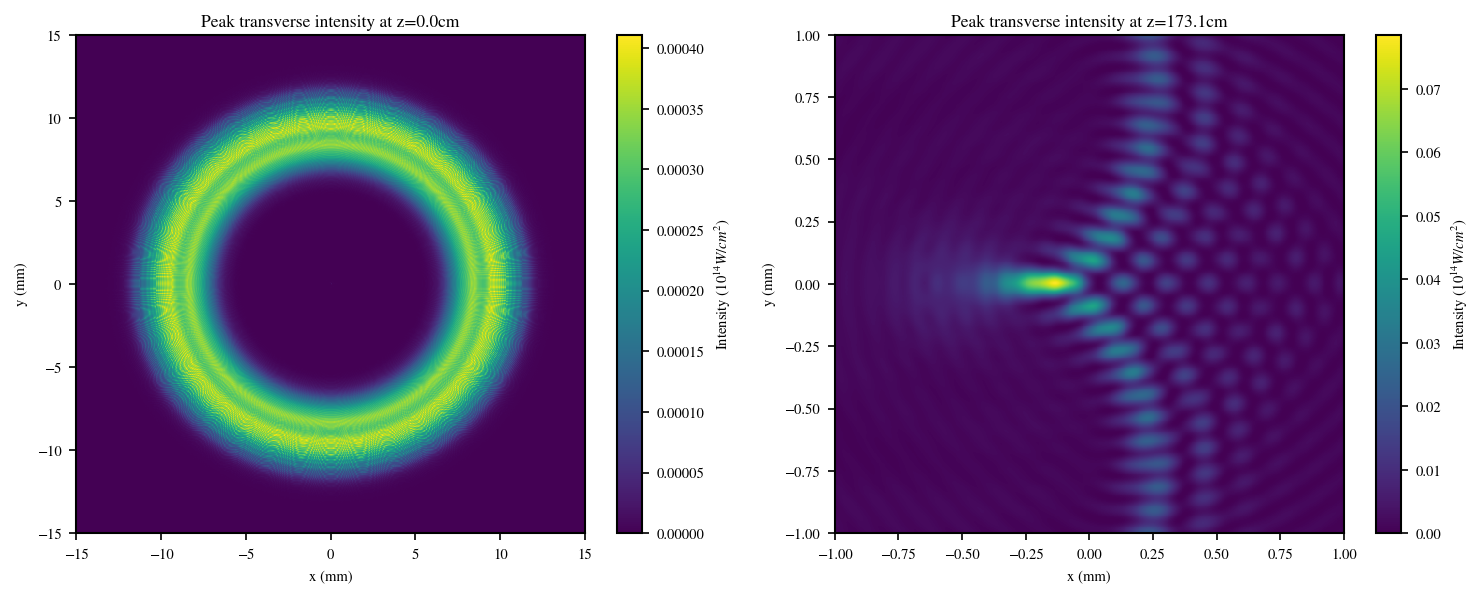

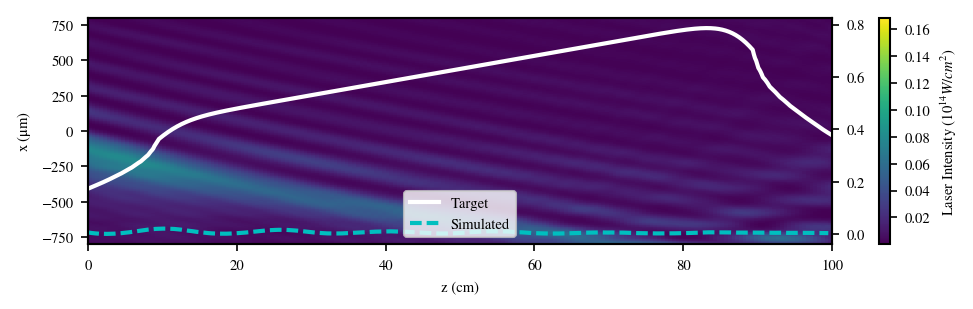

In [17]:
I_0 = get_intensity(100);

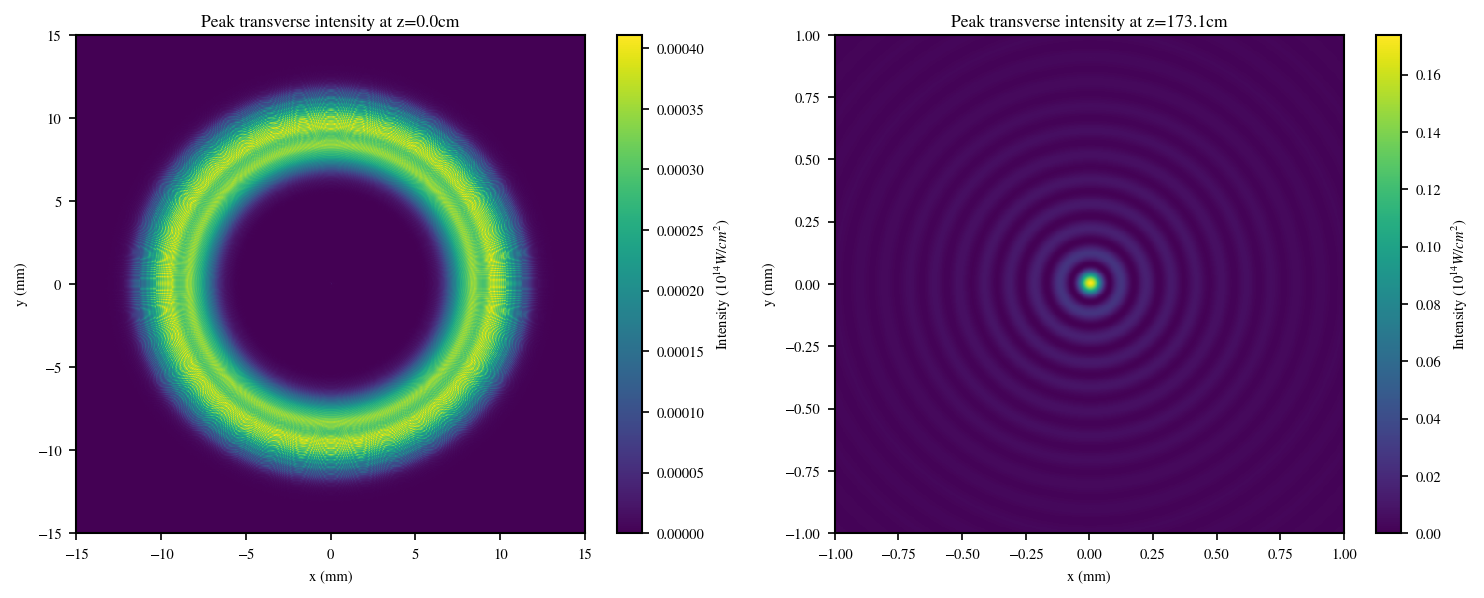

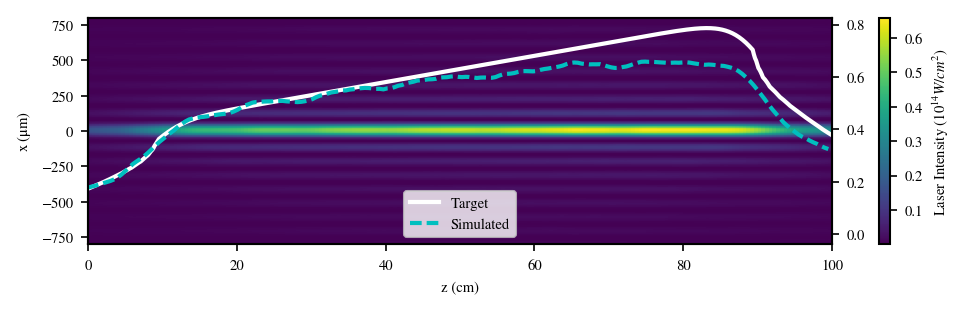

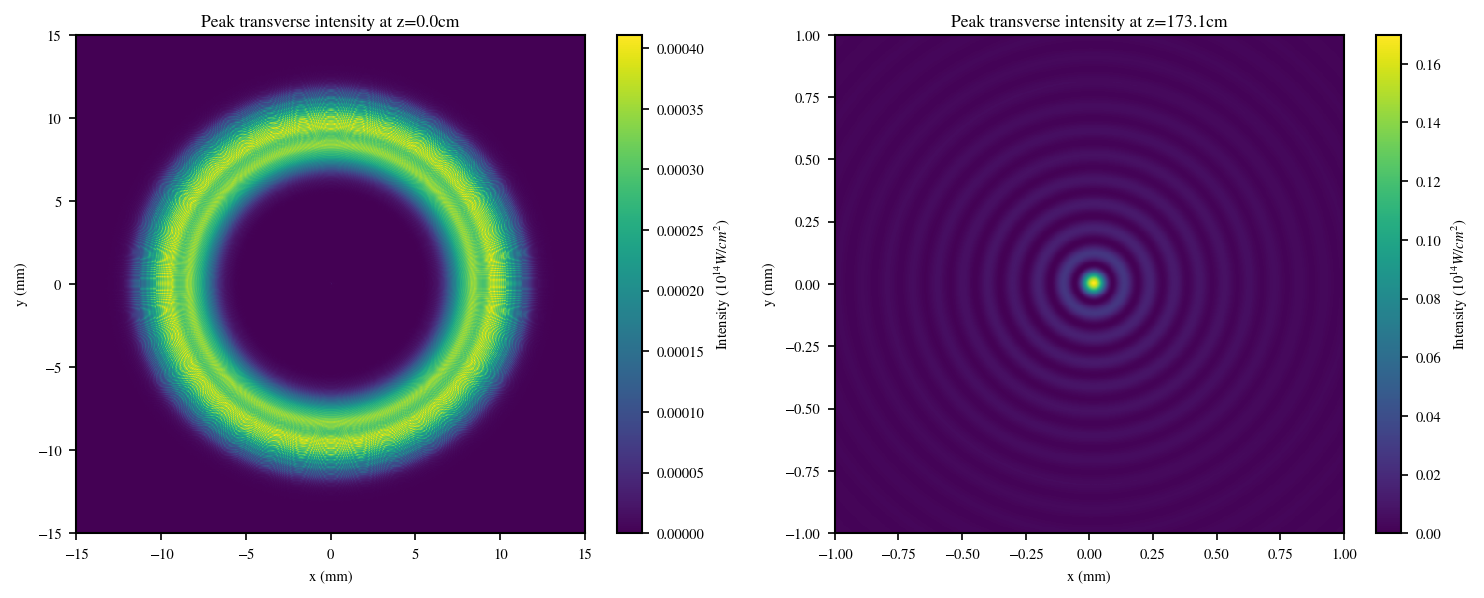

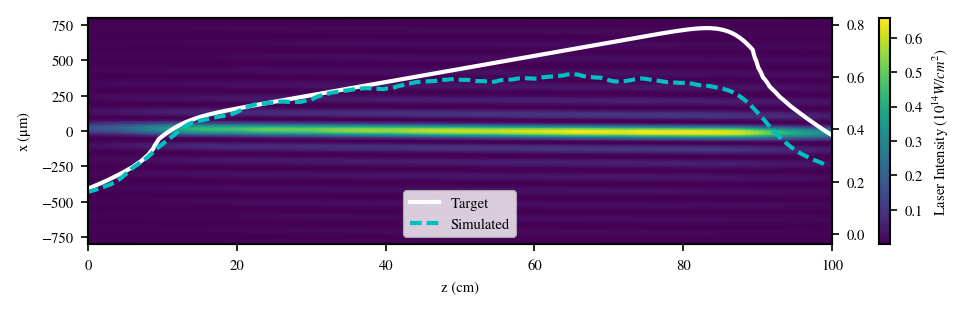

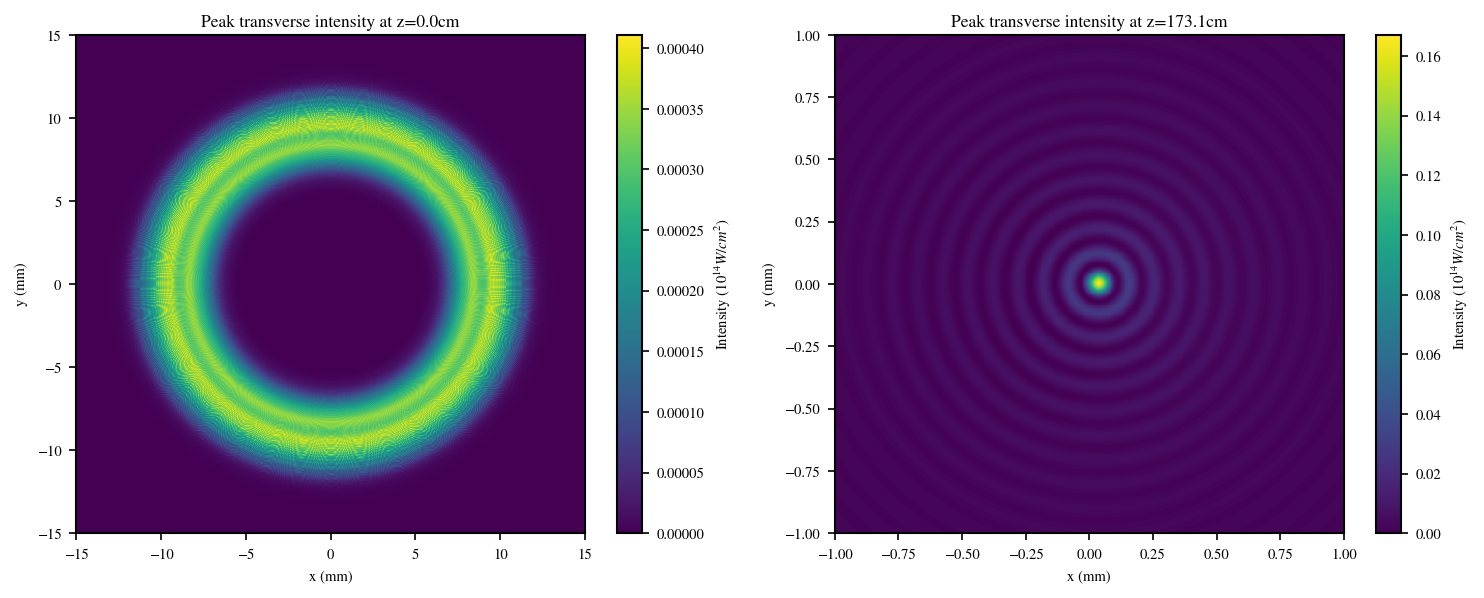

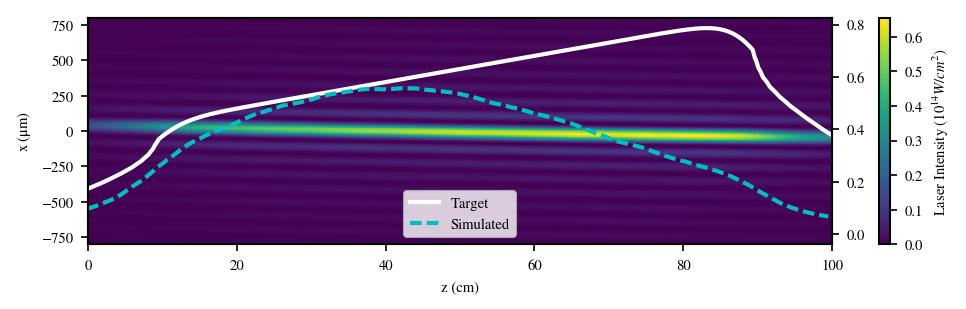

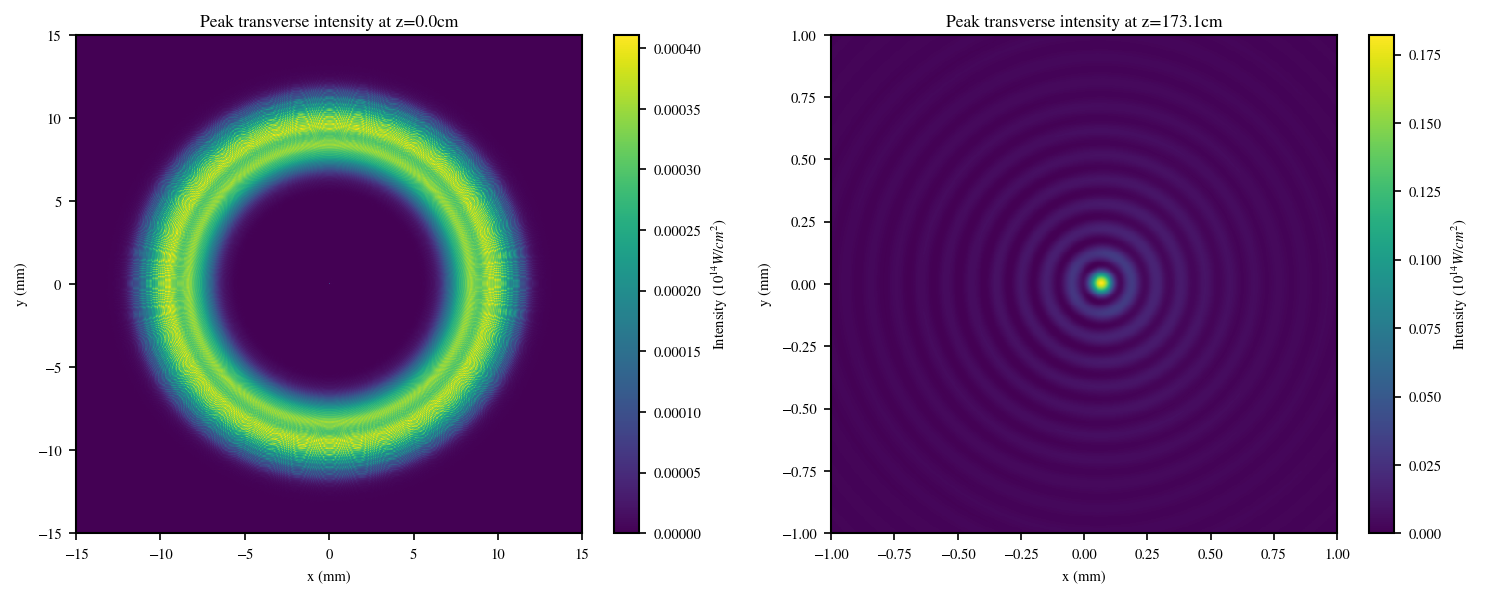

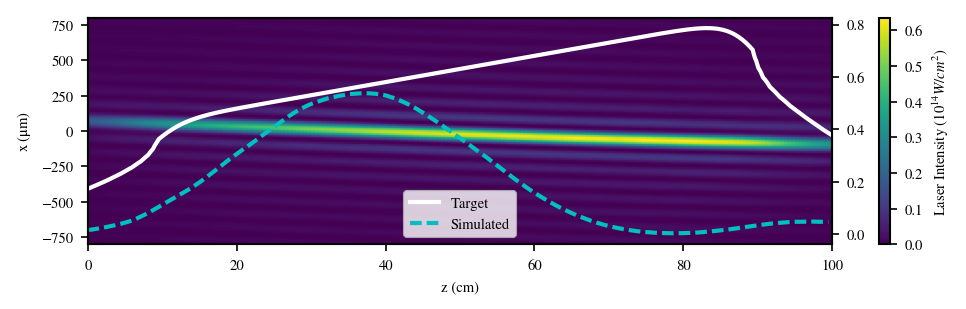

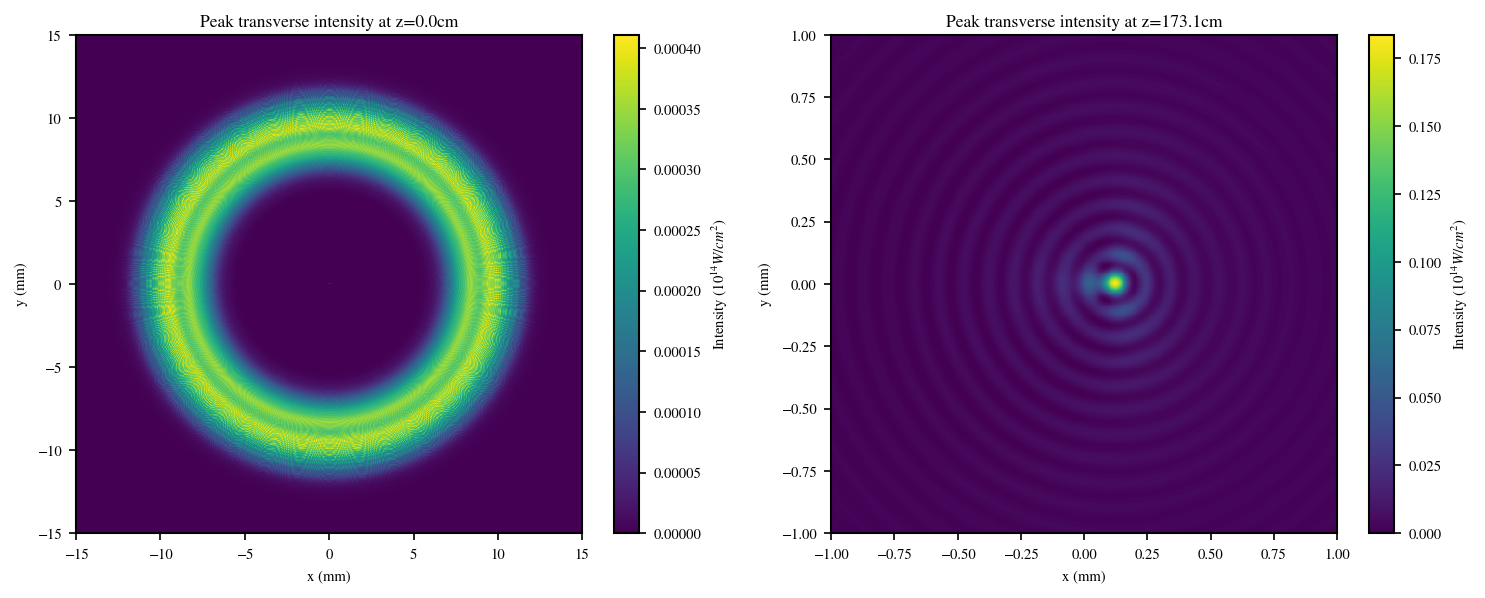

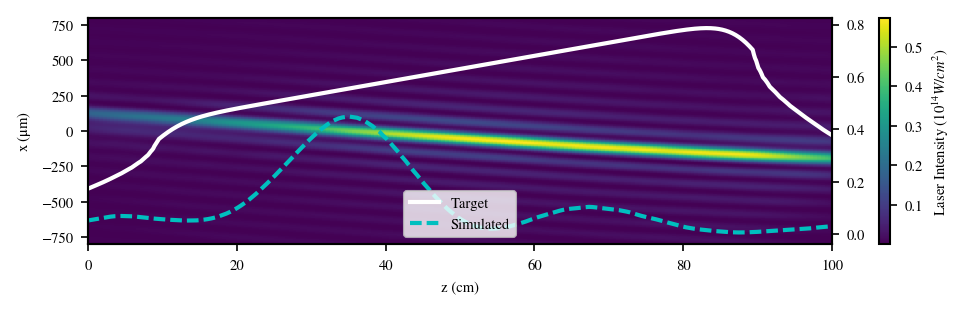

In [18]:
dx = np.array([0, 2, 5, 10, 20])
I_dx = np.zeros((len(dx), Nz, 2**11))
for i in range(len(dx)):
    I_dx[i, :, :] = get_intensity(dx[i])

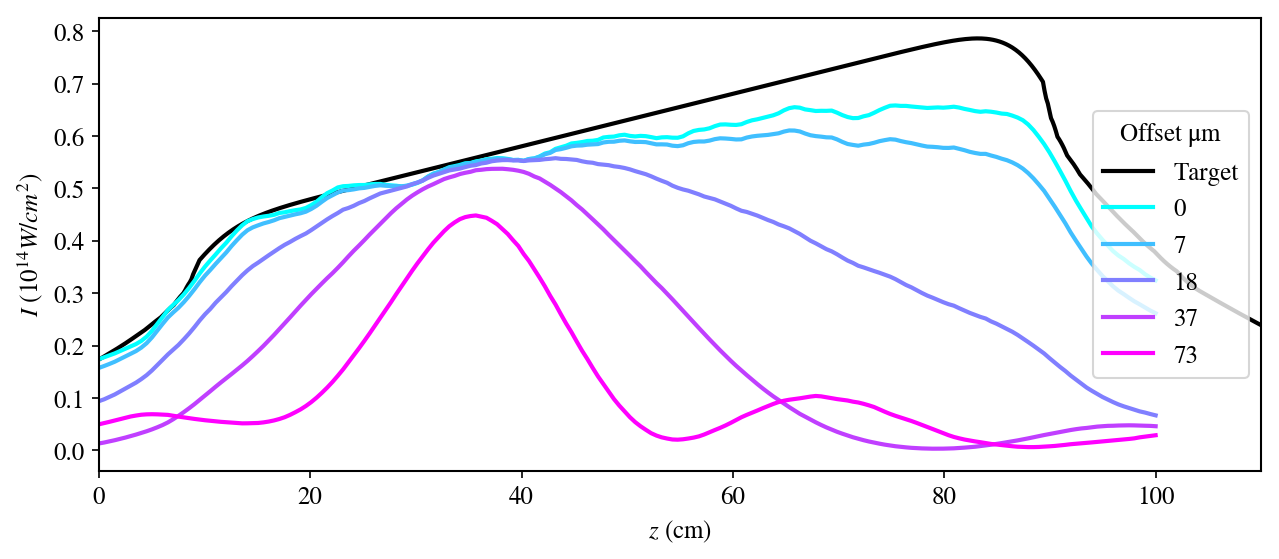

In [19]:
plt.style.use('presentation')
z = np.linspace(0, Z, Nz)
dz = z[1]-z[0]
start = z0-10e4
plt.figure(figsize=(10, 4), dpi=150)
colors = [plt.cm.cool(i) for i in np.linspace(0, 1, len(dx))]
ax = plt.subplot()
ax.set_prop_cycle('color', colors)
plt.xlabel(r'$z$ (cm)')
plt.ylabel(r'$I$ ($10^{14} W/cm^2$)')
plt.plot((z_optic-start-dz)/1e4, I_optic, 'k-', label='Target')
for i in range(len(dx)):
    plt.plot(z/1e4, I_dx[i, :, int(Nx/2)], label='%0.0f'%(dx[i]*3.66))
plt.legend(loc=7, title=r'Offset $\mathrm{\mu m}$')
plt.xlim(0, Z/1e4+10)
plt.show()

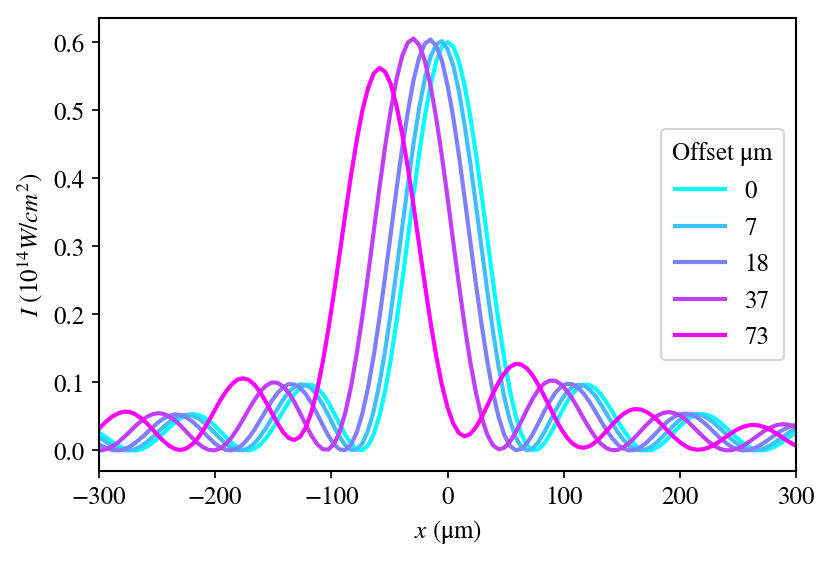

In [20]:
plt.figure(figsize=(6, 4), dpi=150)
colors = [plt.cm.cool(i) for i in np.linspace(0, 1, len(dx))]
x = np.linspace(-X/2, X/2, Nx, endpoint=False)
ax = plt.subplot()
ax.set_prop_cycle('color', colors)
plt.xlabel(r'$x$ ($\mathrm{\mu m}$)')
plt.ylabel(r'$I$ ($10^{14} W/cm^2$)')
for i in range(len(dx)):
    plt.plot(x, I_dx[i, int(Nz/2), :], label='%0.0f'%(dx[i]*3.66))
plt.legend(loc=7, title=r'Offset $\mathrm{\mu m}$')
plt.xlim(-300, 300)
plt.show()
plt.style.use('notes')

In [21]:
I_bl = design.propagate_down_beampipe(pulse, [0.8548e6, 1.2e6, 2e6], [4e3, 5e3, 20e3], 20e3, 2**10, 400)

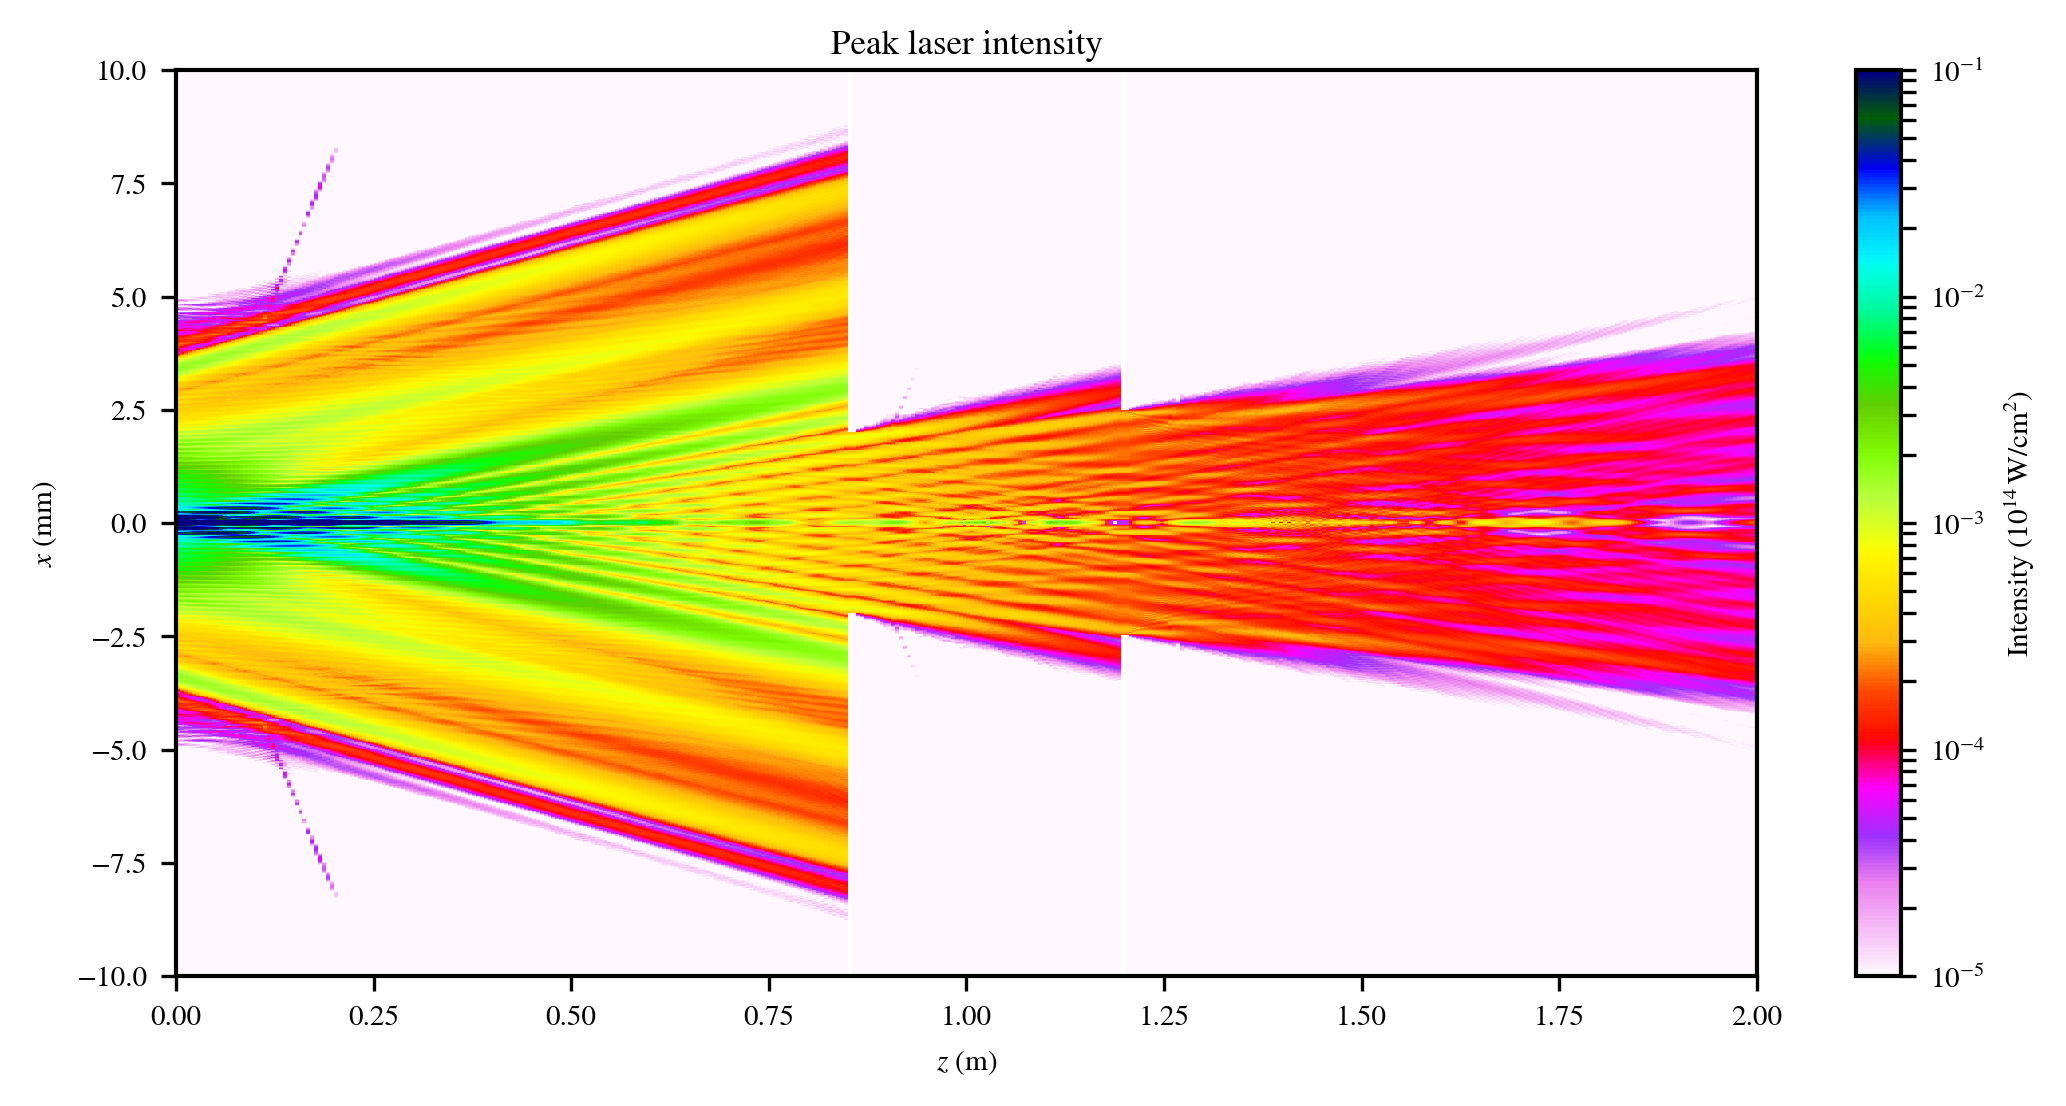

In [22]:
Z = 2e6
X = 20e3
import matplotlib.colors as colors
plt.figure(figsize=(8.5, 4), dpi=300)
norm = colors.LogNorm(vmin=1e-5, vmax=0.1)
im = plt.imshow(I_bl, aspect='auto', extent=[0, Z/1e6, -X/2e3, X/2e3], norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,\mathrm{W/cm^2}$)')
plt.set_cmap('gist_ncar_r')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$x$ (mm)')
plt.title('Peak laser intensity')
plt.show()